In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
import subprocess
import numpy as np
import json

In [7]:
re_pattern = r"Time elapsed: (\d+) milliseconds"
RESOLUTIONS = [1000, 2000, 4000, 8000, 16000]
RUNS = 1

# Best params CUDA

In [58]:
BLOCKDIM_Y = BLOCKDIM_X = [1, 2, 4, 8, 16, 32]

In [ ]:
time_matrix_blockdim_by_resolution = {}

for r, resolution in enumerate(RESOLUTIONS[:4]):
    time_matrix = np.zeros((len(BLOCKDIM_X), len(BLOCKDIM_Y)))

    for run in range(RUNS):
        for i, block_x in enumerate(BLOCKDIM_X):
            for j, block_y in enumerate(BLOCKDIM_Y):
                print(f"{block_x=}, {block_y=}, {resolution=}")
                command = f"make cuda BLOCKDIM_X={block_x} BLOCKDIM_Y={block_y} RESOLUTION={resolution} && ./release/mandelbrot_cuda"
                result = subprocess.run(command, shell=True, capture_output=True, text=True)
                match = re.search(re_pattern, result.stdout)
                if match:
                    time_elapsed = int(match.group(1))
                    time_matrix[i, j] += time_elapsed
                else:
                    print(f"[DEBUG] No match found in stdout for elapsed time.")
    time_matrix /= RUNS # average

    time_matrix_blockdim_by_resolution[r] = time_matrix

block_x=1, block_y=1
block_x=1, block_y=2
block_x=1, block_y=4
block_x=1, block_y=8
block_x=1, block_y=16
block_x=1, block_y=32
block_x=2, block_y=1
block_x=2, block_y=2
block_x=2, block_y=4
block_x=2, block_y=8
block_x=2, block_y=16
block_x=2, block_y=32
block_x=4, block_y=1
block_x=4, block_y=2
block_x=4, block_y=4
block_x=4, block_y=8
block_x=4, block_y=16
block_x=4, block_y=32
block_x=8, block_y=1
block_x=8, block_y=2
block_x=8, block_y=4
block_x=8, block_y=8
block_x=8, block_y=16
block_x=8, block_y=32
block_x=16, block_y=1
block_x=16, block_y=2
block_x=16, block_y=4
block_x=16, block_y=8
block_x=16, block_y=16
block_x=16, block_y=32
block_x=32, block_y=1
block_x=32, block_y=2
block_x=32, block_y=4
block_x=32, block_y=8
block_x=32, block_y=16
block_x=32, block_y=32


In [ ]:
best_time = np.inf
best_config = None

# iterate over each resolution's time matrix
for r, matrix in time_matrix_blockdim_by_resolution.items():
  # Find the indices of the minimum time in the current matrix
  i_min, j_min = np.unravel_index(np.argmin(matrix), matrix.shape)
  # Update the best time and configuration if the current minimum time is better
  if matrix[i_min, j_min] < best_time:
    best_time = matrix[i_min, j_min]
    best_config = (BLOCKDIM_X[i_min], BLOCKDIM_Y[j_min])

print(f"Best overall CUDA BLOCKDIM: block_x = {best_config} with time {best_time}")

Best blockdim_x: 4, Best blockdim_y: 8


# CPU best params

In [4]:
NUM_THREADS_LIST = [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
# NUM_THREADS_LIST = [1, 2, 4, 6]
SCHEDULE_LIST = ["static", "dynamic", "guided"]

In [25]:
import subprocess
import re
import numpy as np
import json

best_cpu_param_times = np.zeros((len(NUM_THREADS_LIST), len(SCHEDULE_LIST), len(RESOLUTIONS)))

results_dict = {}

for run in range(RUNS):
    print(f"Run {run + 1}")
    for r, resolution in enumerate(RESOLUTIONS[:3]):
      for i, nthreads in enumerate(NUM_THREADS_LIST):
          for j, schedule in enumerate(SCHEDULE_LIST):
              print(f"nthreads={nthreads}, schedule={schedule}, resolution={resolution}")
              
              # Modify the command to run in a single bash shell
              command = f"bash -c 'cd /home/Zsf/HPC/mandelbrot && source /opt/intel/oneapi/setvars.sh > /dev/null && make NUM_THREADS={nthreads} OMP_SCHEDULE={schedule} RESOLUTION={resolution} && ./release/mandelbrot'"
      
              # Run the command and capture both stdout and stderr
              result = subprocess.run(command, shell=True, capture_output=True, text=True)
              
              # Print both stdout and stderr
              print("STDOUT:")
              print(result.stdout)
              print("STDERR:")
              print(result.stderr)
              
              # Check if the elapsed time matches the regex
              match = re.search(re_pattern, result.stdout)
              if match:
                  time_elapsed = int(match.group(1))
                  best_cpu_param_times[i, j, r] = time_elapsed
                  
                  # Add the result to the dictionary
                  if resolution not in results_dict:
                        results_dict[resolution] = {}
                  if nthreads not in results_dict[resolution]:
                      results_dict[resolution][nthreads] = {}
                  results_dict[resolution][nthreads][schedule] = time_elapsed
              else:
                  print(f"[DEBUG] No match found in stdout for elapsed time.")

# Average the results over the number of runs
best_cpu_param_times /= RUNS

# Save the results dictionary to a JSON file
output_filename = "./data/cpu_param_times.json"
with open(output_filename, 'w') as f:
    json.dump(results_dict, f, indent=4)

print(f"Results saved to {output_filename}")


Run 1
nthreads=1, schedule=static, resolution=1000
STDOUT:
icpx -g -O3 -march=native -qopenmp -qopt-report=3 -ffast-math \
	-D PARALLEL \
	-D NUM_THREADS=1 \
	-D OMP_SCHEDULE=static \
	-D RESOLUTION=1000 \
	./src/mandelbrot.cpp -o ./release/mandelbrot
Image size: 0.0223517 GB
Time elapsed: 3402 milliseconds.
Writing to file...
Please specify the output file as a parameter.

STDERR:

nthreads=1, schedule=dynamic, resolution=1000
STDOUT:
icpx -g -O3 -march=native -qopenmp -qopt-report=3 -ffast-math \
	-D PARALLEL \
	-D NUM_THREADS=1 \
	-D OMP_SCHEDULE=dynamic \
	-D RESOLUTION=1000 \
	./src/mandelbrot.cpp -o ./release/mandelbrot
Image size: 0.0223517 GB
Time elapsed: 3416 milliseconds.
Writing to file...
Please specify the output file as a parameter.

STDERR:

nthreads=1, schedule=guided, resolution=1000
STDOUT:
icpx -g -O3 -march=native -qopenmp -qopt-report=3 -ffast-math \
	-D PARALLEL \
	-D NUM_THREADS=1 \
	-D OMP_SCHEDULE=guided \
	-D RESOLUTION=1000 \
	./src/mandelbrot.cpp -o ./relea

In [16]:
best_cpu_param_times

array([[3400., 3397., 3403.],
       [1703., 1729., 1708.],
       [1407.,  866.,  859.],
       [1092.,  582.,  571.],
       [ 898.,  440.,  437.],
       [ 705.,  380.,  376.],
       [ 670.,  338.,  356.],
       [ 564.,  312.,  316.],
       [ 498.,  288.,  291.],
       [ 523.,  267.,  266.],
       [ 394.,  252.,  251.]])

In [15]:
i_min, j_min = np.unravel_index(np.argmin(best_cpu_param_times), best_cpu_param_times.shape)
print(f"Best parameters: nthreads={NUM_THREADS_LIST[i_min]}, schedule={SCHEDULE_LIST[j_min]}")

Best parameters: nthreads=20, schedule=guided


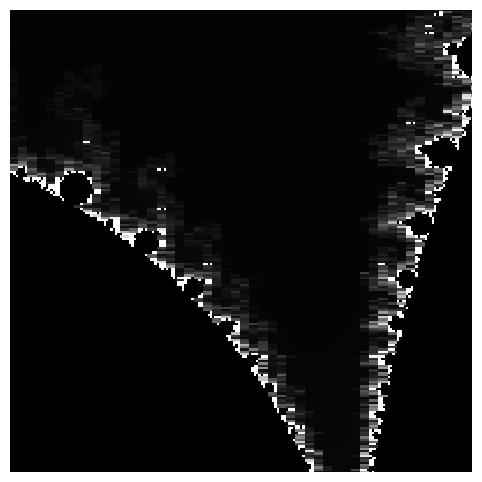

In [2]:
data = np.loadtxt('result_1000.csv', delimiter=',')

plt.figure(figsize=(10, 6))
plt.imshow(data, cmap='gray', origin='lower', interpolation='nearest')
plt.xlim(1100, 1300)
plt.ylim(1100, 1300)
plt.axis('off')
plt.show()

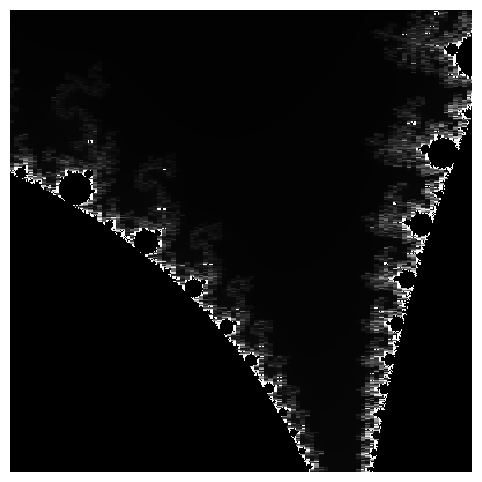

In [3]:
data = np.loadtxt('result_2000.csv', delimiter=',')

plt.figure(figsize=(10, 6))
plt.imshow(data, cmap='gray', origin='lower', interpolation='nearest')
plt.xlim(1100 * 2, 1300 * 2)
plt.ylim(1100 * 2, 1300 * 2)
plt.axis('off')
plt.show()

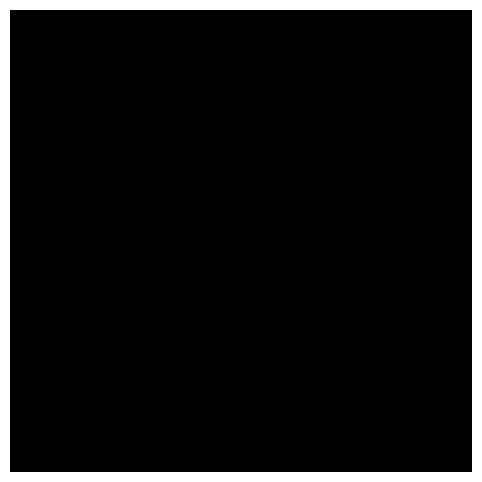

In [11]:
data_small = np.loadtxt('result_4000.csv', delimiter=',', max_rows=2000)

plt.figure(figsize=(10, 6))
plt.imshow(data_small, cmap='gray', interpolation='nearest')
# Use the same portion as before (e.g. rows and columns 1100 to 1300)
plt.xlim(1100, 1300)
plt.ylim(1100, 1300)
plt.axis('off')
plt.show()
